In [4]:
# Cell: Environment check (fixed)
import sys
import torch
import random
import numpy as np

print('Python:', sys.version.replace('\n', ' '))
print('PyTorch:', torch.__version__)
print('Torchvision: try import...')
try:
    import torchvision
    print('Torchvision:', torchvision.__version__)
except Exception as e:
    print('Import torchvision failed:', e)

print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA device count:', torch.cuda.device_count())
    try:
        print('Current device name:', torch.cuda.get_device_name(0))
    except Exception:
        pass

# Reproducibility helper
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print('Seed set to 42')


Python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
PyTorch: 2.9.0+cpu
Torchvision: try import...
Torchvision: 0.24.0+cpu
CUDA available: False
Seed set to 42


In [40]:
import torchvision.models as models

def load_pretrained(model_name='resnet50', use_pretrained=True):
    model_name = model_name.lower()
    
    if model_name == 'resnet18':
        try:
            weights = models.ResNet18_Weights.IMAGENET1K_V1
            model = models.resnet18(weights=weights if use_pretrained else None)
        except Exception:
            model = models.resnet18(pretrained=use_pretrained)
        input_size = 224

    elif model_name == 'resnet50':
        try:
            weights = models.ResNet50_Weights.IMAGENET1K_V2
            model = models.resnet50(weights=weights if use_pretrained else None)
        except Exception:
            model = models.resnet50(pretrained=use_pretrained)
        input_size = 224

    elif model_name == 'vgg16':
        try:
            weights = models.VGG16_Weights.IMAGENET1K_V1
            model = models.vgg16(weights=weights if use_pretrained else None)
        except Exception:
            model = models.vgg16(pretrained=use_pretrained)
        input_size = 224

    elif model_name == 'densenet121':
        try:
            weights = models.DenseNet121_Weights.IMAGENET1K_V1
            model = models.densenet121(weights=weights if use_pretrained else None)
        except Exception:
            model = models.densenet121(pretrained=use_pretrained)
        input_size = 224

    elif model_name == 'efficientnet_b0':
        try:
            weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
            model = models.efficientnet_b0(weights=weights if use_pretrained else None)
        except Exception:
            model = models.efficientnet_b0(pretrained=use_pretrained)
        input_size = 224

    else:
        raise ValueError('Model not supported in this helper')

    return model, input_size


In [41]:
model, input_size = load_pretrained('resnet18')
print(model.__class__.__name__, '-', 'Input size:', input_size)


ResNet - Input size: 224


In [42]:
# Print top-level architecture (cẩn thận với output dài)
print(model)

# Helper: tìm Linear cuối cùng và in_features
from collections import OrderedDict
import torch.nn as nn

def find_final_linear(model):
    final_name = None
    final_module = None
    for name, module in model.named_modules():
        # lấy linear cuối cùng
        if isinstance(module, nn.Linear):
            final_name = name
            final_module = module
    return final_name, final_module


# Gọi hàm helper
final_name, final_module = find_final_linear(model)

print('\nFinal linear layer name:', final_name)
if final_module is not None:
    print('Final linear layer:', final_module)
    try:
        print('in_features =', final_module.in_features, 'out_features =', final_module.out_features)
    except Exception:
        pass
else:
    print('Không tìm thấy Linear cuối cùng một cách tự động — kiểm tra model cụ thể (ví dụ VGG dùng model.classifier)')


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
# %%
num_classes = 10  # sửa theo dataset của bạn

# Một số quy tắc phổ biến theo loại model
if hasattr(model, 'fc') and isinstance(model.fc, nn.Linear):
    # ResNet-like
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    print('Replaced model.fc for ResNet-like model')

elif hasattr(model, 'classifier'):
    # VGG, DenseNet, EfficientNet thường có .classifier
    # VGG: classifier là Sequential, thay phần tử cuối
    if isinstance(model.classifier, nn.Sequential):
        # tìm phần tử Linear cuối cùng trong classifier
        idx = None
        for i, m in enumerate(model.classifier):
            if isinstance(m, nn.Linear):
                idx = i
        if idx is not None:
            in_features = model.classifier[idx].in_features
            # build copy
            new_classifier = list(model.classifier.children())
            new_classifier[idx] = nn.Linear(in_features, num_classes)
            model.classifier = nn.Sequential(*new_classifier)
            print('Replaced last Linear in model.classifier')
        else:
            print('Không tìm thấy Linear trong classifier')

    else:
        # classifier là 1 Linear (DenseNet, EfficientNet)
        try:
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, num_classes)
            print('Replaced model.classifier (single Linear)')
        except Exception as e:
            print('Không thể tự động thay classifier:', e)

else:
    print('Không nhận diện được lớp cuối — vui lòng sửa thủ công theo model bạn dùng')


Replaced model.fc for ResNet-like model


In [44]:
# %%
# Freeze all params (feature extraction)
def freeze_all(model):
    for p in model.parameters():
        p.requires_grad = False
    print("✅ All model parameters have been frozen (feature extraction mode).")


In [45]:
# %%
# Unfreeze last N parameters (naive approach: based on named parameters order)
def unfreeze_last_n_params(model, n=10):
    params = list(model.named_parameters())
    if n <= 0:
        return
    for name, param in params[-n:]:
        param.requires_grad = True
        print('🔓 Unfreezing', name)


In [46]:
# %%
# Example usage:
freeze_all(model)

# Only classifier params should be trainable now
print('\nTrainable params after freeze:')
for name, p in model.named_parameters():
    if p.requires_grad:
        print('\t', name)

# If you want to fine-tune last N params instead of only classifier
unfreeze_last_n_params(model, n=20)

# Quick forward pass test with dummy input
batch_size = 2
dummy = torch.randn(batch_size, 3, input_size, input_size)
model.eval()
with torch.no_grad():
    out = model(dummy)
    print('\nForward pass output shape:', out.shape)


✅ All model parameters have been frozen (feature extraction mode).

Trainable params after freeze:
🔓 Unfreezing layer3.1.conv2.weight
🔓 Unfreezing layer3.1.bn2.weight
🔓 Unfreezing layer3.1.bn2.bias
🔓 Unfreezing layer4.0.conv1.weight
🔓 Unfreezing layer4.0.bn1.weight
🔓 Unfreezing layer4.0.bn1.bias
🔓 Unfreezing layer4.0.conv2.weight
🔓 Unfreezing layer4.0.bn2.weight
🔓 Unfreezing layer4.0.bn2.bias
🔓 Unfreezing layer4.0.downsample.0.weight
🔓 Unfreezing layer4.0.downsample.1.weight
🔓 Unfreezing layer4.0.downsample.1.bias
🔓 Unfreezing layer4.1.conv1.weight
🔓 Unfreezing layer4.1.bn1.weight
🔓 Unfreezing layer4.1.bn1.bias
🔓 Unfreezing layer4.1.conv2.weight
🔓 Unfreezing layer4.1.bn2.weight
🔓 Unfreezing layer4.1.bn2.bias
🔓 Unfreezing fc.weight
🔓 Unfreezing fc.bias

Forward pass output shape: torch.Size([2, 10])


In [61]:
# ---------- STEP 5: Prepare data ----------
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [68]:
# User: chỉnh đường dẫn này về nơi bạn lưu dataset
# Hỗ trợ 2 kiểu cấu trúc:
# 1) data_dir/train/<class_x>/*.jpg và data_dir/val/<class_x>/*.jpg (recommended)
# 2) data_dir/<class_x>/*.jpg (script sẽ tự chia train/val theo val_split)


data_dir = r'C:\Users\Nguyen Trung An\DL_Practice\flowers'
 # <-- sửa chỗ này
val_split = 0.2
test_split = 0.0 # đặt >0 nếu có thư mục test hoặc muốn chia ra
batch_size = 32
num_workers = 8


# Transforms (ImageNet normalization) — điều chỉnh input_size nếu cần
input_size = 128
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


data_transforms = {
'train': transforms.Compose([
transforms.RandomResizedCrop(input_size),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize(mean, std)
]),
'val': transforms.Compose([
transforms.Resize(int(input_size * 1.15)),
transforms.CenterCrop(input_size),
transforms.ToTensor(),
transforms.Normalize(mean, std)
]),
'test': transforms.Compose([
transforms.Resize(int(input_size * 1.15)),
transforms.CenterCrop(input_size),
transforms.ToTensor(),
transforms.Normalize(mean, std)
])
}

In [69]:
# %%
# Helper to build datasets similar to earlier script
import os, copy
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

def build_image_datasets(data_dir, transforms_dict, val_split=0.2, test_split=0.0, seed=42):
    data_dir = os.path.abspath(data_dir)
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"data_dir {data_dir} not found. Please change the path.")

    # If explicit train/val folders exist
    train_folder = os.path.join(data_dir, 'train')
    val_folder = os.path.join(data_dir, 'val')
    test_folder = os.path.join(data_dir, 'test')

    if os.path.exists(train_folder):
        train_ds = ImageFolder(train_folder, transform=transforms_dict['train'])
        if os.path.exists(val_folder):
            val_ds = ImageFolder(val_folder, transform=transforms_dict['val'])
        else:
            # split train into train/val
            n_total = len(train_ds)
            n_val = int(n_total * val_split)
            n_train = n_total - n_val
            train_ds, val_ds = random_split(
                train_ds, [n_train, n_val],
                generator=torch.Generator().manual_seed(seed)
            )
            # ensure val uses val transform
            val_ds.dataset = copy.copy(train_ds.dataset)
            val_ds.dataset.transform = transforms_dict['val']

        datasets = {'train': train_ds, 'val': val_ds}

        if os.path.exists(test_folder):
            datasets['test'] = ImageFolder(test_folder, transform=transforms_dict['test'])

    else:
        # single folder with class subfolders => split into train/val(/test)
        full = ImageFolder(data_dir, transform=transforms_dict['train'])
        n_total = len(full)
        n_val = int(n_total * val_split)
        n_test = int(n_total * test_split)
        n_train = n_total - n_val - n_test
        if n_train <= 0:
            raise ValueError('Dataset too small or val/test split too large')

        parts = [n_train, n_val] + ([n_test] if n_test > 0 else [])
        splits = random_split(full, parts, generator=torch.Generator().manual_seed(42))

        train_ds = splits[0]
        val_ds = splits[1]
        val_ds.dataset = copy.copy(full)
        val_ds.dataset.transform = transforms_dict['val']

        datasets = {'train': train_ds, 'val': val_ds}

        if n_test > 0:
            test_ds = splits[2]
            test_ds.dataset = copy.copy(full)
            test_ds.dataset.transform = transforms_dict['test']
            datasets['test'] = test_ds

    return datasets


Datasets built:
  train: 3454 images
  val: 863 images
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

Sample batch shapes:
 inputs: torch.Size([32, 3, 128, 128])
 labels: torch.Size([32])


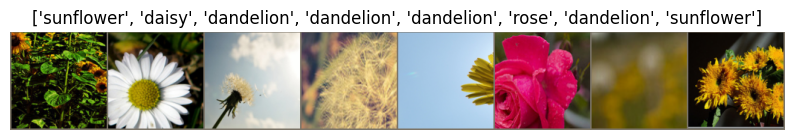

In [70]:
# %%
# Build datasets and dataloaders
image_datasets = build_image_datasets(data_dir, data_transforms, val_split=val_split, test_split=test_split)

from torch.utils.data import DataLoader

dataloaders = {}
dataset_sizes = {}
class_names = None

for phase in image_datasets:
    ds = image_datasets[phase]
    dataloaders[phase] = DataLoader(ds, batch_size=batch_size, shuffle=(phase == 'train'), num_workers=num_workers)
    dataset_sizes[phase] = len(ds)

    # get class names from underlying dataset object
    if isinstance(ds, torch.utils.data.Subset):
        class_names = ds.dataset.classes
    else:
        class_names = ds.classes

print('Datasets built:')
for k, v in dataset_sizes.items():
    print(f'  {k}: {v} images')
print('Classes:', class_names)

# Visualize a batch (unnormalize for display)
import torchvision

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# get a batch
inputs, classes_batch = next(iter(dataloaders['train']))
out_grid = torchvision.utils.make_grid(inputs[:8])

plt.figure(figsize=(10, 4))
imshow(out_grid, title=[class_names[x] for x in classes_batch[:8]])

# Print shapes
print('\nSample batch shapes:')
print(' inputs:', inputs.shape)
print(' labels:', classes_batch.shape)


In [71]:
# ---------- STEP 5.5: Setup model, loss, optimizer, scheduler ----------

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 1️⃣ Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2️⃣ Load pre-trained model (ví dụ: ResNet18)
model_ft = models.resnet18(weights="IMAGENET1K_V1")  # pretrained=True (phiên bản mới)
num_classes = len(class_names)  # số lớp từ dataset của bạn
in_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(in_features, num_classes)

# 3️⃣ Send model to GPU (nếu có)
model_ft = model_ft.to(device)

# 4️⃣ Define loss function
criterion = nn.CrossEntropyLoss()

# 5️⃣ Optimizer — fine-tune toàn bộ hoặc chỉ phần classifier
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 6️⃣ Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 7️⃣ (Optional) In ra số tham số trainable
total_params = sum(p.numel() for p in model_ft.parameters())
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,} | Trainable: {trainable_params:,}")


Using device: cpu
Total parameters: 11,179,077 | Trainable: 11,179,077


In [72]:
# ---------- STEP 6: Train the model ----------

import torch
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torch.utils.tensorboard import SummaryWriter

# --- 1️⃣ Tải model ResNet18 pretrained ---
model_ft, input_size = load_pretrained('resnet18')

# --- 2️⃣ Thay lớp fully connected cuối cùng ---
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# --- 3️⃣ Đưa model lên GPU nếu có ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# --- 4️⃣ Định nghĩa loss, optimizer, scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# --- 5️⃣ Hàm train_model (chuẩn, có log TensorBoard) ---
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    writer = SummaryWriter()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase not in dataloaders:
                continue

            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            writer.add_scalar(f'{phase}/Loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase}/Accuracy', epoch_acc, epoch)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Lưu model tốt nhất (theo val acc)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    writer.close()
    return model


# --- 6️⃣ Chạy train ---
epochs = 5
model_ft = train_model(model_ft, dataloaders, criterion, optimizer, scheduler, num_epochs=epochs)



Epoch 1/5
--------------------
train Loss: 0.8242 Acc: 0.6694
val Loss: 0.4366 Acc: 0.8459

Epoch 2/5
--------------------
train Loss: 0.4509 Acc: 0.8408
val Loss: 0.3537 Acc: 0.8737

Epoch 3/5
--------------------
train Loss: 0.3724 Acc: 0.8674
val Loss: 0.3191 Acc: 0.8783

Epoch 4/5
--------------------
train Loss: 0.3524 Acc: 0.8680
val Loss: 0.3065 Acc: 0.8922

Epoch 5/5
--------------------
train Loss: 0.3338 Acc: 0.8807
val Loss: 0.2898 Acc: 0.8980

Training complete in 8m 44s
Best val Acc: 0.8980



Classification Report:
              precision    recall  f1-score   support

       daisy       0.93      0.84      0.89       167
   dandelion       0.89      0.91      0.90       197
        rose       0.87      0.90      0.88       153
   sunflower       0.93      0.91      0.92       149
       tulip       0.88      0.92      0.90       197

    accuracy                           0.90       863
   macro avg       0.90      0.90      0.90       863
weighted avg       0.90      0.90      0.90       863



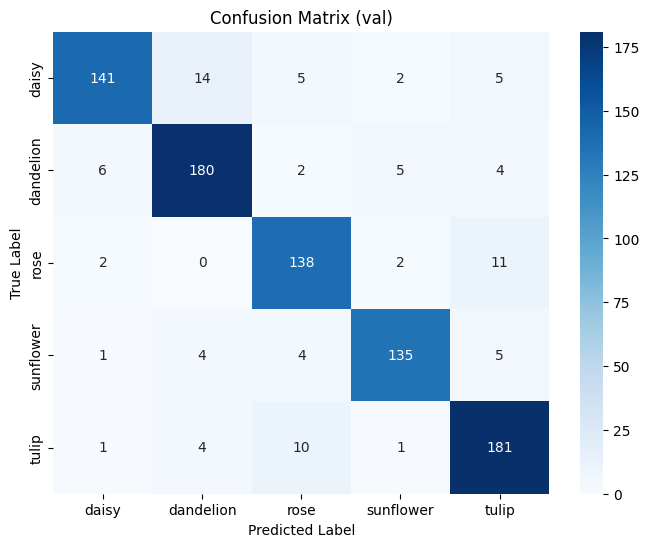


✅ Model saved to: resnet18_flowers_best.pth


In [73]:
# %% [markdown]
# ## Step 7: Evaluate and Save Model

# %%
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Nếu chưa có biến 'experiment_name' thì đặt tạm
experiment_name = "resnet18_flowers"

# --- 1️⃣ Evaluate trên test (nếu có) hoặc val ---
phase = 'test' if 'test' in dataloaders else 'val'
model_ft.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --- 2️⃣ Classification Report ---
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=class_names))

# --- 3️⃣ Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix ({phase})')
plt.show()

# --- 4️⃣ Save model ---
model_path = f'{experiment_name}_best.pth'
torch.save(model_ft.state_dict(), model_path)
print(f'\n✅ Model saved to: {model_path}')


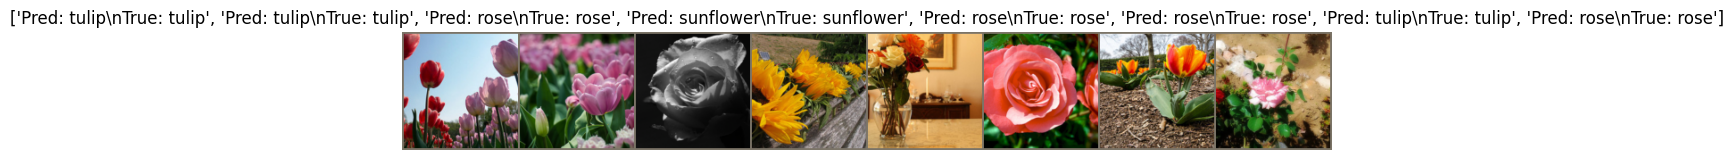

✅ Hiển thị kết quả dự đoán hoàn tất.


In [74]:
# ---------- STEP 7: Evaluate and visualize predictions ----------

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

# Đặt model sang chế độ đánh giá
model_ft.eval()

# Lấy class names từ dataloader
class_names = image_datasets['train'].dataset.classes \
    if isinstance(image_datasets['train'], torch.utils.data.Subset) \
    else image_datasets['train'].classes

# Hàm hiển thị ảnh (bỏ chuẩn hóa)
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Lấy 1 batch ảnh từ dataloader (nếu có tập 'val' thì dùng val)
phase_to_use = 'val' if 'val' in dataloaders else 'train'
inputs, labels = next(iter(dataloaders[phase_to_use]))
inputs = inputs.to(device)
labels = labels.to(device)

# Dự đoán
with torch.no_grad():
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

# Hiển thị 8 ảnh đầu tiên
plt.figure(figsize=(12, 6))
out = torchvision.utils.make_grid(inputs[:8])
imshow(out, title=[f"Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}"
                   for j in range(8)])
plt.show()

print("✅ Hiển thị kết quả dự đoán hoàn tất.")
